# FTDI Device Info

In [3]:
from pyftdi.ftdi import Ftdi

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            # entry can be (UsbDeviceDescriptor, interface) or similar
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            # UsbDeviceDescriptor fields
            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04x}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04x}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : {serial or 'Unknown'}")
            print(f"   Description : {description or 'Unknown'}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : ￿￿￿￿￿￿￿￿
   Description : ￿￿￿￿￿￿
   Interfaces  : 1



In [4]:
from pyftdi.ftdi import Ftdi

def safe_to_hex_string(value):
    """Return UTF-8 string if printable, else show hex representation."""
    if value is None:
        return 'None'
    try:
        if all(0x20 <= ord(c) <= 0x7E for c in value):
            return value  # printable ASCII
        else:
            raise UnicodeEncodeError
    except Exception:
        return ' '.join(f'{ord(c):02X}' for c in value)

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04X}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04X}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : 0x{safe_to_hex_string(serial)}")
            print(f"   Description : 0x{safe_to_hex_string(description)}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : 0xFFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF
   Description : 0xFFFF FFFF FFFF FFFF FFFF FFFF
   Interfaces  : 1



# FTDI FT232H Sanity Test

In [6]:
from pyftdi.ftdi import Ftdi
from pyftdi.i2c import I2cController
from IPython.display import display, Markdown
import traceback

'''
Bus Rate
-  100 kHz ... default
-  400 kHz
- 1000 kHz
'''

BUS_RATE = 1e6


display(Markdown("## 🔍 FT232H Sanity Test"))

try:
    display(Markdown("**🔹 Scanning for FTDI devices...**"))
    Ftdi.show_devices()
except Exception as e:
    display(Markdown(f"❌ **Could not list FTDI devices:** `{e}`"))
    traceback.print_exc()
else:
    try:
        display(Markdown("**🔹 Initializing I2C interface...**"))
        i2c = I2cController()
        i2c.configure('ftdi://ftdi:232h/1', frequency=BUS_RATE) 


        freq = i2c.frequency
        display(Markdown(f"✅ **Connected to FT232H via I2C** at **{freq/1000:.1f} kHz**"))

        # ✅ Manually scan I2C addresses 0x03–0x77
        display(Markdown("**🔹 Scanning I2C bus...**"))
        found = []
        for addr in range(0x03, 0x78):
            try:
                port = i2c.get_port(addr)
                port.read(1)  # Try reading one byte (safe test)
                found.append(addr)
            except Exception:
                # No device responded
                pass

        if found:
            md = "\n".join([f"- `0x{addr:02X}`" for addr in found])
            display(Markdown(f"✅ **Found I2C devices:**\n{md}"))
        else:
            display(Markdown("⚠️ **No I2C devices detected.** Check wiring or power."))

        i2c.terminate()
        display(Markdown("✅ **Test complete — FT232H is working properly.**"))

    except Exception as e:
        display(Markdown(f"❌ **Failed to communicate with FT232H:** `{e}`"))
        traceback.print_exc()


## 🔍 FT232H Sanity Test

**🔹 Scanning for FTDI devices...**

Available interfaces:
  ftdi://ftdi:232h:1/1  (￿￿￿￿￿￿)



**🔹 Initializing I2C interface...**

✅ **Connected to FT232H via I2C** at **1000.0 kHz**

**🔹 Scanning I2C bus...**

✅ **Found I2C devices:**
- `0x68`

✅ **Test complete — FT232H is working properly.**

# MPU6050

In [53]:
from pyftdi.i2c import I2cController
import struct, time, sys

# --- MPU-6050 constants ---
MPU_ADDR      = 0x68
PWR_MGMT_1    = 0x6B
ACCEL_XOUT_H  = 0x3B

BUS_RATE = 1e6

# --- Initialize I2C via FT232H ---
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency={}'.format(BUS_RATE))  
mpu = i2c.get_port(MPU_ADDR)

# --- Wake up sensor ---
mpu.write_to(PWR_MGMT_1, b'\x00')
time.sleep(0.1)

# --- Read and convert raw data ---
def read_mpu6050():
    raw = mpu.exchange([ACCEL_XOUT_H], 14)
    ax, ay, az, temp, gx, gy, gz = struct.unpack('>hhhhhhh', raw)
    return {
        'ax': ax / 16384.0,  # g
        'ay': ay / 16384.0,
        'az': az / 16384.0,
        'gx': gx / 131.0,    # °/s
        'gy': gy / 131.0,
        'gz': gz / 131.0,
        'temp': temp / 340.0 + 36.53
    }

# --- Continuous read loop ---
print("Streaming MPU6050 data... (Ctrl+C to stop)\n")
try:
    while True:
        d = read_mpu6050()
        line = (f"A=({d['ax']:+.2f}, {d['ay']:+.2f}, {d['az']:+.2f}) g   "
                f"G=({d['gx']:+6.1f}, {d['gy']:+6.1f}, {d['gz']:+6.1f}) °/s   "
                f"T={d['temp']:.2f} °C\r")
        sys.stdout.write(line)
        sys.stdout.flush()
        time.sleep(0.05)  # ~20 Hz refresh
except KeyboardInterrupt:
    print("\nStopped by user.")
finally:
    i2c.terminate()


Streaming MPU6050 data... (Ctrl+C to stop)

A=(+1.02, +0.01, -0.25) g   G=(  -1.4,   +0.5,   +1.5) °/s   T=25.61 °C
Stopped by user.


In [100]:
from pyftdi.i2c import I2cController
import struct, time

MPU_ADDR = 0x68

# MPU-6050 Register Map
REG_PWR_MGMT_1   = 0x6B
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A   # DLPF_CFG
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_2   = 0x6C
REG_WHO_AM_I     = 0x75

# Initialize FT232H I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency=400000')
mpu = i2c.get_port(MPU_ADDR)

print(f"✅ Connected to FT232H. Scanning for MPU-6050 at 0x{MPU_ADDR:02X}...\n")

try:
    # --- Helpers ---
    def write_reg(port, reg, value):
        """Write one byte to a register"""
        port.write([reg, value & 0xFF])
        time.sleep(0.01)

    def read_reg(port, reg):
        """Read one byte from a register"""
        raw = port.read_from(reg, 1)
        return raw[0]

    def read_whoami(port):
        whoami = read_reg(port, REG_WHO_AM_I)
        print(f"🆔 WHO_AM_I: 0x{whoami:02X} {'✅ OK' if whoami == 0x68 else '⚠️ Unexpected'}")

    # --- Write configuration ---
    def write_config(port,
                     dlpf_cfg=3,          # DLPF bandwidth (0–6)
                     gyro_fs_sel=0,       # Gyro full-scale ±250–2000 °/s
                     accel_fs_sel=0,      # Accel full-scale ±2–16 g
                     fifo_enable=True,
                     dmp_enable=False):
        """
        Configure MPU6050: DLPF, gyro/accel ranges, FIFO, DMP, etc.
        """

        print("🛠️ Writing configuration to MPU-6050...\n")

        # Wake up device
        write_reg(port, REG_PWR_MGMT_1, 0x00)

        # Set DLPF
        write_reg(port, REG_CONFIG, dlpf_cfg & 0x07)

        # Gyro full-scale range
        gyro_val = (gyro_fs_sel & 0x03) << 3
        write_reg(port, REG_GYRO_CONFIG, gyro_val)

        # Accel full-scale range
        accel_val = (accel_fs_sel & 0x03) << 3
        write_reg(port, REG_ACCEL_CONFIG, accel_val)

        # FIFO Enable
        fifo_val = 0x78 if fifo_enable else 0x00  # Enable all gyro+accel
        write_reg(port, REG_FIFO_EN, fifo_val)

        # USER_CTRL (DMP/FIFO control)
        user_ctrl = (0x40 if fifo_enable else 0x00) | (0x80 if dmp_enable else 0x00)
        write_reg(port, REG_USER_CTRL, user_ctrl)

        print(f"✅ DLPF_CFG  : {dlpf_cfg} → bandwidth config")
        print(f"✅ GYRO FS   : ±{[250,500,1000,2000][gyro_fs_sel]} °/s")
        print(f"✅ ACCEL FS  : ±{[2,4,8,16][accel_fs_sel]} g")
        print(f"✅ FIFO_EN   : {'ON' if fifo_enable else 'OFF'}")
        print(f"✅ DMP_EN    : {'ON' if dmp_enable else 'OFF'}")

    # --- Read & decode configuration ---
    def read_config(port):
        """Read and decode MPU6050 config registers."""
        print("\n📖 Reading MPU-6050 configuration...\n")

        dlpf_cfg = read_reg(port, REG_CONFIG) & 0x07
        gyro_cfg = (read_reg(port, REG_GYRO_CONFIG) >> 3) & 0x03
        accel_cfg = (read_reg(port, REG_ACCEL_CONFIG) >> 3) & 0x03
        fifo_en = read_reg(port, REG_FIFO_EN)
        user_ctrl = read_reg(port, REG_USER_CTRL)

        dlpf_table = {
            0: "256 Hz (fastest, low delay)",
            1: "188 Hz",
            2: "98 Hz",
            3: "42 Hz (balanced)",
            4: "20 Hz",
            5: "10 Hz",
            6: "5 Hz (max smoothing)",
        }

        gyro_range = ["±250°/s", "±500°/s", "±1000°/s", "±2000°/s"]
        accel_range = ["±2g", "±4g", "±8g", "±16g"]

        print(f"🧠 DLPF_CFG   : {dlpf_cfg} → {dlpf_table.get(dlpf_cfg,'Reserved')}")
        print(f"🧭 Gyro Range : {gyro_range[gyro_cfg]}")
        print(f"   Accel Range: {accel_range[accel_cfg]}")
        print(f"📦 FIFO_EN    : 0x{fifo_en:02X} ({'Enabled' if fifo_en else 'Disabled'})")
        print(f"⚙️  USER_CTRL : 0x{user_ctrl:02X} "
              f"(FIFO={'ON' if user_ctrl & 0x40 else 'OFF'}, "
              f"DMP={'ON' if user_ctrl & 0x80 else 'OFF'})")

    # --- Execute sequence ---
    read_whoami(mpu)

    write_config(
        mpu,
        dlpf_cfg=3,         # 42 Hz filter
        gyro_fs_sel=0,      # ±250 °/s
        accel_fs_sel=0,     # ±2 g
        fifo_enable=True,
        dmp_enable=False
    )

    read_config(mpu)

except Exception as e:
    print(f"❌ Could not communicate with MPU-6050: {e}")

finally:
    i2c.terminate()
    print("\n🔚 I2C connection closed.")


✅ Connected to FT232H. Scanning for MPU-6050 at 0x68...

🆔 WHO_AM_I: 0x68 ✅ OK
🛠️ Writing configuration to MPU-6050...

✅ DLPF_CFG  : 3 → bandwidth config
✅ GYRO FS   : ±250 °/s
✅ ACCEL FS  : ±2 g
✅ FIFO_EN   : ON
✅ DMP_EN    : OFF

📖 Reading MPU-6050 configuration...

🧠 DLPF_CFG   : 3 → 42 Hz (balanced)
🧭 Gyro Range : ±250°/s
   Accel Range: ±2g
📦 FIFO_EN    : 0x78 (Enabled)
⚙️  USER_CTRL : 0x40 (FIFO=ON, DMP=OFF)

🔚 I2C connection closed.


# FIFO

- On each I2C read, all complete 6 DoF samples in the FIFO are transmitted

In [46]:
from pyftdi.i2c import I2cController
import struct, time, sys

MPU_ADDR = 0x68

# Registers
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_INT_ENABLE   = 0x38
REG_INT_STATUS   = 0x3A
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_1   = 0x6B
REG_PWR_MGMT_2   = 0x6C
REG_FIFO_COUNTH  = 0x72
REG_FIFO_COUNTL  = 0x73
REG_FIFO_R_W     = 0x74
REG_WHO_AM_I     = 0x75

# Scales
ACCEL_SCALE = 16384.0  # ±2 g
GYRO_SCALE  = 131.0    # ±250 °/s

data_log = []

# I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency=400000')  # use 100k if you prefer
mpu = i2c.get_port(MPU_ADDR)

# ---- helpers (use exchange()/write_to like your working code) ----
def write8(reg, val):
    mpu.write_to(reg, bytes([val & 0xFF]))
    time.sleep(0.002)

def read8(reg):
    return mpu.exchange([reg], 1)[0]

def read16_be(reg):
    return struct.unpack('>H', mpu.exchange([reg], 2))[0]

def fifo_read(nbytes):
    # IMPORTANT: use exchange with the FIFO register address
    return mpu.exchange([REG_FIFO_R_W], nbytes)

def fifo_reset():
    # toggle reset bit then clear
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) | 0x04)
    time.sleep(0.01)
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x04)
    time.sleep(0.01)

def dump_regs():
    regs = [
        ("WHO_AM_I",     REG_WHO_AM_I),
        ("PWR_MGMT_1",   REG_PWR_MGMT_1),
        ("PWR_MGMT_2",   REG_PWR_MGMT_2),
        ("CONFIG",       REG_CONFIG),
        ("SMPLRT_DIV",   REG_SMPLRT_DIV),
        ("GYRO_CONFIG",  REG_GYRO_CONFIG),
        ("ACCEL_CONFIG", REG_ACCEL_CONFIG),
        ("USER_CTRL",    REG_USER_CTRL),
        ("FIFO_EN",      REG_FIFO_EN),
        ("INT_ENABLE",   REG_INT_ENABLE),
        ("INT_STATUS",   REG_INT_STATUS),
    ]
    print("\n🔎 Register dump:")
    for name, r in regs:
        print(f"   {name:<14}= 0x{read8(r):02X}")
    print()

def init_mpu_soft_fifo():
    # No hard reset: many clones NACK after 0x80 reset. Keep it simple.
    write8(REG_PWR_MGMT_1, 0x01)      # PLL X-gyro
    write8(REG_PWR_MGMT_2, 0x00)      # all sensors ON
    time.sleep(0.05)

    # Basic config
    write8(REG_CONFIG, 0x03)          # DLPF 42 Hz
    write8(REG_SMPLRT_DIV, 0x04)      # 1kHz/(1+4) = 200 Hz
    write8(REG_GYRO_CONFIG, 0x00)     # ±250 °/s
    write8(REG_ACCEL_CONFIG, 0x00)    # ±2 g

    # Ensure FIFO & DMP/I2C master are off, then reset FIFO
    write8(REG_USER_CTRL, 0x00)
    write8(REG_FIFO_EN, 0x00)
    fifo_reset()

    # Give ADC a moment to start producing valid samples
    time.sleep(0.05)

    # Enable FIFO logic and select accel+gyro
    write8(REG_USER_CTRL, 0x40)       # FIFO_EN bit (logic enable)
    write8(REG_FIFO_EN, 0x78)         # TEMP=0, XG|YG|ZG|ACCEL=1
    write8(REG_INT_ENABLE, 0x01)      # data-ready interrupt (optional)

    # Clear any stale interrupt
    _ = read8(REG_INT_STATUS)

def stream_fifo():
    print("📡 Streaming FIFO data (Ctrl+C to stop)\n")

    t0 = time.time()
    last_print = 0
    data_log = []

    try:
        while True:
            fifo_count = read16_be(REG_FIFO_COUNTH)

            if fifo_count > 1020:
                fifo_reset()
                continue
            if fifo_count < 12:
                time.sleep(0.005)
                continue

            to_read = (fifo_count // 12) * 12
            blob = fifo_read(to_read)

            for i in range(0, len(blob), 12):
                ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+12])
                axf, ayf, azf = ax/ACCEL_SCALE, ay/ACCEL_SCALE, az/ACCEL_SCALE
                gxf, gyf, gzf = gx/GYRO_SCALE, gy/GYRO_SCALE, gz/GYRO_SCALE

                data_log.append({
                    't': time.time(),
                    'ax': axf, 'ay': ayf, 'az': azf,
                    'gx': gxf, 'gy': gyf, 'gz': gzf
                })

            # ✅ only print every 0.1 s
            now = time.time()
            if now - last_print >= 0.01:
                last_print = now
                sys.stdout.write(
                    f"\rA=({axf:+.2f},{ayf:+.2f},{azf:+.2f}) g  "
                    f"G=({gxf:+6.1f},{gyf:+6.1f},{gzf:+6.1f}) °/s     "
                )
                sys.stdout.flush()

    except KeyboardInterrupt:
        print("\n🛑 Stopped by user.")
    finally:
        print(f"📦 Recorded {len(data_log)} samples.")
        return data_log

       

try:
    who = read8(REG_WHO_AM_I)
    print(f"🆔 WHO_AM_I = 0x{who:02X}")
    if who != 0x68:
        print("⚠️ Unexpected WHO_AM_I (check address AD0/wiring)")

    print("🛠️ Initializing (soft init, no hard reset)...")
    init_mpu_soft_fifo()
    dump_regs()

    # Quick sanity: make sure FIFO_count rises
    for t in (0.05, 0.10, 0.20):
        time.sleep(t)
        cnt = read16_be(REG_FIFO_COUNTH)
        print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    data_log = stream_fifo()

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")
except Exception as e:
    print(f"\n❌ Communication error: {e}")
finally:
    # Clean shutdown
    try:
        write8(REG_FIFO_EN, 0x00)
        write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x40)
    except Exception:
        pass
    i2c.terminate()
    print("🔚 FIFO disabled, I²C connection closed.")


🆔 WHO_AM_I = 0x68
🛠️ Initializing (soft init, no hard reset)...

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x01

FIFO count @ +50 ms: 792
FIFO count @ +100 ms: 1024
FIFO count @ +200 ms: 1024
📡 Streaming FIFO data (Ctrl+C to stop)

A=(+1.02,+0.01,-0.27) g  G=(  -1.6,  +0.4,  +1.5) °/s     
🛑 Stopped by user.
📦 Recorded 5468 samples.
🔚 FIFO disabled, I²C connection closed.


### Add Temperature

In [128]:
from pyftdi.i2c import I2cController
import struct, time, sys

MPU_ADDR = 0x68

# Registers
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_INT_ENABLE   = 0x38
REG_INT_STATUS   = 0x3A
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_1   = 0x6B
REG_PWR_MGMT_2   = 0x6C
REG_FIFO_COUNTH  = 0x72
REG_FIFO_COUNTL  = 0x73
REG_FIFO_R_W     = 0x74
REG_WHO_AM_I     = 0x75

# Scales
ACCEL_SCALE = 16384.0  # ±2 g
GYRO_SCALE  = 131.0    # ±250 °/s

data_log = []

# I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency=400000')  # use 100k if you prefer
mpu = i2c.get_port(MPU_ADDR)

# ---- helpers (use exchange()/write_to like your working code) ----
def write8(reg, val):
    mpu.write_to(reg, bytes([val & 0xFF]))
    time.sleep(0.002)

def read8(reg):
    return mpu.exchange([reg], 1)[0]

def read16_be(reg):
    return struct.unpack('>H', mpu.exchange([reg], 2))[0]

def fifo_read(nbytes):
    # IMPORTANT: use exchange with the FIFO register address
    return mpu.exchange([REG_FIFO_R_W], nbytes)

def fifo_reset():
    # toggle reset bit then clear
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) | 0x04)
    time.sleep(0.01)
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x04)
    time.sleep(0.01)

def dump_regs():
    regs = [
        ("WHO_AM_I",     REG_WHO_AM_I),
        ("PWR_MGMT_1",   REG_PWR_MGMT_1),
        ("PWR_MGMT_2",   REG_PWR_MGMT_2),
        ("CONFIG",       REG_CONFIG),
        ("SMPLRT_DIV",   REG_SMPLRT_DIV),
        ("GYRO_CONFIG",  REG_GYRO_CONFIG),
        ("ACCEL_CONFIG", REG_ACCEL_CONFIG),
        ("USER_CTRL",    REG_USER_CTRL),
        ("FIFO_EN",      REG_FIFO_EN),
        ("INT_ENABLE",   REG_INT_ENABLE),
        ("INT_STATUS",   REG_INT_STATUS),
    ]
    print("\n🔎 Register dump:")
    for name, r in regs:
        print(f"   {name:<14}= 0x{read8(r):02X}")
    print()

def init_mpu_soft_fifo():
    # No hard reset: many clones NACK after 0x80 reset. Keep it simple.
    write8(REG_PWR_MGMT_1, 0x01)      # PLL X-gyro
    write8(REG_PWR_MGMT_2, 0x00)      # all sensors ON
    time.sleep(0.05)

    # Basic config
    write8(REG_CONFIG, 0x03)          # DLPF 42 Hz
    write8(REG_SMPLRT_DIV, 0x04)      # 1kHz/(1+4) = 200 Hz
    write8(REG_GYRO_CONFIG, 0x00)     # ±250 °/s
    write8(REG_ACCEL_CONFIG, 0x00)    # ±2 g

    # Ensure FIFO & DMP/I2C master are off, then reset FIFO
    write8(REG_USER_CTRL, 0x00)
    write8(REG_FIFO_EN, 0x00)
    fifo_reset()

    # Give ADC a moment to start producing valid samples
    time.sleep(0.05)

    # Enable FIFO logic and select accel+gyro
    write8(REG_USER_CTRL, 0x40)       # FIFO_EN bit (logic enable)
    write8(REG_FIFO_EN, 0x78)         # TEMP=0, XG|YG|ZG|ACCEL=1
    write8(REG_INT_ENABLE, 0x01)      # data-ready interrupt (optional)

    # Clear any stale interrupt
    _ = read8(REG_INT_STATUS)

def stream_fifo():
    print("📡 Streaming FIFO data (Ctrl+C to stop)\n")

    t0 = time.time()
    last_print = 0
    data_log = []

    try:
        while True:
            fifo_count = read16_be(REG_FIFO_COUNTH)

            if fifo_count > 1020:
                fifo_reset()
                continue
            if fifo_count < 12:
                time.sleep(0.005)
                continue

            # Read temperature once per batch
            # raw = read16_be(0x41)
            # raw = ((raw << 8) & 0xFF00) | ((raw >> 8) & 0x00FF)
            # if raw >= 0x8000:
            #     raw -= 0x10000
            # temp_c = raw / 340.0 + 36.53

            h = read8(0x41)   # TEMP_OUT_H
            l = read8(0x42)   # TEMP_OUT_L
            raw = (h << 8) | l
            if raw >= 0x8000:
                raw -= 0x10000
            temp_c = raw / 340.0 + 36.53  # per datasheet

            to_read = (fifo_count // 12) * 12
            blob = fifo_read(to_read)

            for i in range(0, len(blob), 12):
                ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+12])
                axf, ayf, azf = ax/ACCEL_SCALE, ay/ACCEL_SCALE, az/ACCEL_SCALE
                gxf, gyf, gzf = gx/GYRO_SCALE, gy/GYRO_SCALE, gz/GYRO_SCALE

                data_log.append({
                    't': time.time(),
                    'ax': axf, 'ay': ayf, 'az': azf,
                    'gx': gxf, 'gy': gyf, 'gz': gzf,
                    'temp': temp_c
                })

            now = time.time()
            if now - last_print >= 0.01:
                last_print = now
                sys.stdout.write(
                    f"\rA=({axf:+.2f},{ayf:+.2f},{azf:+.2f}) g  "
                    f"G=({gxf:+6.1f},{gyf:+6.1f},{gzf:+6.1f}) °/s     "
                    f"T={temp_c:0.2f}°C     "
                    f"n_samples={len(data_log)}"
                )
                sys.stdout.flush()

    except KeyboardInterrupt:
        print("\n🛑 Stopped by user.")
    finally:
        print(f"📦 Recorded {len(data_log)} samples.")
        return data_log

       

try:
    who = read8(REG_WHO_AM_I)
    print(f"🆔 WHO_AM_I = 0x{who:02X}")
    if who != 0x68:
        print("⚠️ Unexpected WHO_AM_I (check address AD0/wiring)")

    print("🛠️ Initializing (soft init, no hard reset)...")
    init_mpu_soft_fifo()
    dump_regs()

    # Quick sanity: make sure FIFO_count rises
    for t in (0.05, 0.10, 0.20):
        time.sleep(t)
        cnt = read16_be(REG_FIFO_COUNTH)
        print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    data_log = stream_fifo()

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")
except Exception as e:
    print(f"\n❌ Communication error: {e}")
finally:
    # Clean shutdown
    try:
        write8(REG_FIFO_EN, 0x00)
        write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x40)
    except Exception:
        pass
    i2c.terminate()
    print("🔚 FIFO disabled, I²C connection closed.")


🆔 WHO_AM_I = 0x68
🛠️ Initializing (soft init, no hard reset)...

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x01

FIFO count @ +50 ms: 804
FIFO count @ +100 ms: 1024
FIFO count @ +200 ms: 1024
📡 Streaming FIFO data (Ctrl+C to stop)

A=(+1.02,+0.02,-0.24) g  G=(  -1.4,  +0.5,  +1.4) °/s     T=20.98°C     n_samples=1180
🛑 Stopped by user.
📦 Recorded 1180 samples.
🔚 FIFO disabled, I²C connection closed.


📊 Recorded 1180 samples over 5.847 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 201.6 Hz → Δt = 4.96 ms


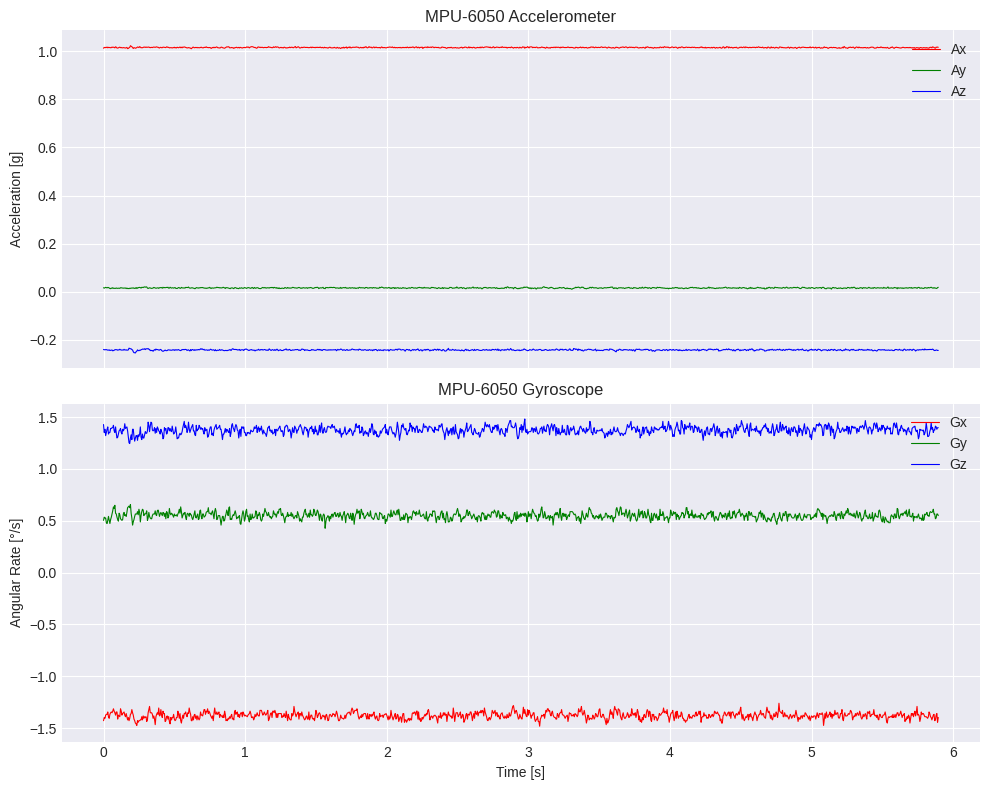

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["ax"] for d in data_log])
    ay = np.array([d["ay"] for d in data_log])
    az = np.array([d["az"] for d in data_log])
    gx = np.array([d["gx"] for d in data_log])
    gy = np.array([d["gy"] for d in data_log])
    gz = np.array([d["gz"] for d in data_log])

    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(data_log)

In [78]:
import pandas as pd
df = pd.DataFrame(data_log)
df

,t,ax,ay,az,gx,gy,gz,temp
0,1.760371e+09,1.018433,0.006836,-0.255737,-1.458015,0.480916,1.442748,25.435882
1,1.760371e+09,1.017700,0.008057,-0.252441,-1.396947,0.496183,1.412214,25.435882
2,1.760371e+09,1.018433,0.008789,-0.254517,-1.412214,0.534351,1.442748,25.435882
3,1.760371e+09,1.019653,0.010620,-0.252197,-1.404580,0.519084,1.496183,25.435882
4,1.760371e+09,1.017700,0.010620,-0.252930,-1.435115,0.549618,1.503817,25.435882
...,...,...,...,...,...,...,...,...
2036,1.760371e+09,1.017822,0.009888,-0.255981,-1.389313,0.572519,1.480916,25.494706
2037,1.760371e+09,1.017944,0.009155,-0.256714,-1.442748,0.580153,1.480916,25.494706
2038,1.760371e+09,1.019775,0.008667,-0.255737,-1.374046,0.519084,1.519084,25.494706
2039,1.760371e+09,1.021118,0.009277,-0.255005,-1.351145,0.519084,1.488550,25.494706


In [103]:
import numpy as np
import pandas as pd

def analyze_mpu6050_stats(data_log, as_dataframe=True, verbose=True):
    """
    Compute descriptive statistics for each signal in a recorded MPU6050 data_log.

    Each entry in data_log must be a dict:
        {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}

    Returns:
        - A dict or pandas.DataFrame with summary stats for each signal.
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to analyze.")
        return None

    # Extract signals as arrays
    signals = {k: np.array([d[k] for d in data_log]) for k in data_log[0].keys() if k != 't'}

    stats = {}
    for name, arr in signals.items():
        mean = np.mean(arr)
        std = np.std(arr)
        minv = np.min(arr)
        maxv = np.max(arr)
        rms = np.sqrt(np.mean(arr**2))
        peak_to_peak = maxv - minv
        median = np.median(arr)
        mad = np.mean(np.abs(arr - mean))  # mean absolute deviation
        stats[name] = {
            "mean": mean,
            "std": std,
            "min": minv,
            "max": maxv,
            "peak_to_peak": peak_to_peak,
            "median": median,
            "mad": mad,
            "rms": rms,
        }

    # --- Optional: time base sanity ---
    t = np.array([d["t"] for d in data_log])
    duration = t[-1] - t[0]
    rate = len(t) / duration if duration > 0 else 0
    stats["meta"] = {"samples": len(t), "duration_s": duration, "rate_est_Hz": rate}

    if as_dataframe:
        df = pd.DataFrame(stats).T  # transpose for nice row-per-signal format
        if verbose:
            print("📊 MPU-6050 Signal Statistics:\n")
            print(df.round(6))
        return df
    else:
        if verbose:
            print(stats)
        return stats

analyze_mpu6050_stats(data_log)

📊 MPU-6050 Signal Statistics:

           mean       std        min        max  peak_to_peak     median  \
ax     1.018621  0.001554   0.859131   1.232422      0.373291   1.018677   
ay     0.009230  0.001412  -0.027710   0.055786      0.083496   0.009277   
az    -0.258427  0.001970  -0.281372  -0.228149      0.053223  -0.258423   
gx    -1.386042  0.036365  -1.572519  -1.221374      0.351145  -1.389313   
gy     0.505725  0.036432  -0.641221   1.916031      2.557252   0.503817   
gz     1.454363  0.037216  -0.847328   3.274809      4.122137   1.458015   
temp  25.467484  0.167115  24.482941  25.985882      1.502941  25.471176   
meta        NaN       NaN        NaN        NaN           NaN        NaN   

           mad        rms   samples   duration_s  rate_est_Hz  
ax    0.001144   1.018622       NaN          NaN          NaN  
ay    0.001117   0.009338       NaN          NaN          NaN  
az    0.001567   0.258434       NaN          NaN          NaN  
gx    0.029068   1.386519   

,mean,std,min,max,peak_to_peak,median,mad,rms,samples,duration_s,rate_est_Hz
ax,1.018621,0.001554,0.859131,1.232422,0.373291,1.018677,0.001144,1.018622,NaN,NaN,NaN
ay,0.009230,0.001412,-0.027710,0.055786,0.083496,0.009277,0.001117,0.009338,NaN,NaN,NaN
az,-0.258427,0.001970,-0.281372,-0.228149,0.053223,-0.258423,0.001567,0.258434,NaN,NaN,NaN
gx,-1.386042,0.036365,-1.572519,-1.221374,0.351145,-1.389313,0.029068,1.386519,NaN,NaN,NaN
gy,0.505725,0.036432,-0.641221,1.916031,2.557252,0.503817,0.028939,0.507036,NaN,NaN,NaN
gz,1.454363,0.037216,-0.847328,3.274809,4.122137,1.458015,0.029160,1.454839,NaN,NaN,NaN
temp,25.467484,0.167115,24.482941,25.985882,1.502941,25.471176,0.129142,25.468032,NaN,NaN,NaN
meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299910.0,1498.001955,200.206681
